Training LogisticTorch model...
Training sklearn LogisticRegression model...

Model Performance Comparison
LogisticTorch Accuracy:  0.8500 (85.00%)
Sklearn Accuracy:        0.8500 (85.00%)



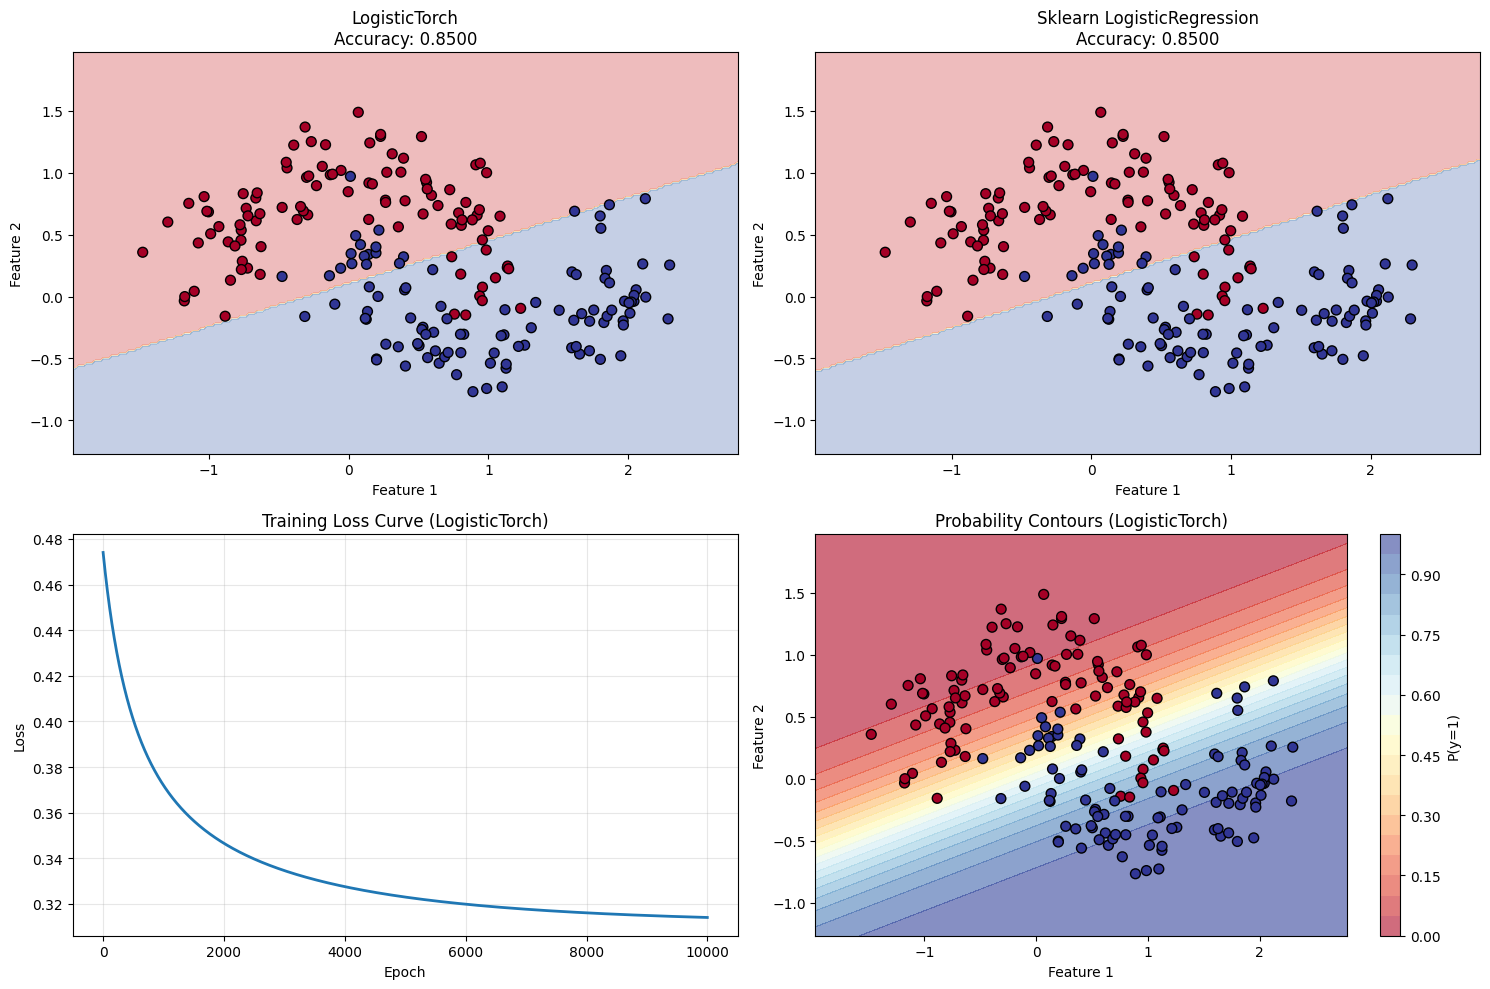

Model Parameters Comparison:
LogisticTorch weights: [ 1.2406837 -3.5709176]
LogisticTorch bias:    0.3768

Sklearn weights:       [ 1.14245894 -3.17942994]
Sklearn bias:          0.3359

Final loss (LogisticTorch): 0.314093


In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


class LogisticTorch:
    def __init__(self, lr=0.01, epochs=1000):
        """
        Initialize Logistic Regression model.

        Args:
            lr: Learning rate for gradient descent
            epochs: Number of training iterations
        """
        self.lr = lr
        self.epochs = epochs
        self.weights = None
        self.bias = None
        self.loss_history = []

    def fit(self, X, y):
        """
        Train the logistic regression model.

        Args:
            X: Training features (numpy array or tensor)
            y: Training labels (numpy array or tensor)
        """
        # Convert to PyTorch tensors
        if not isinstance(X, torch.Tensor):
            X = torch.FloatTensor(X)
        if not isinstance(y, torch.Tensor):
            y = torch.FloatTensor(y)

        n_samples, n_features = X.shape

        # Initialize weights and bias
        self.weights = torch.randn(n_features, requires_grad=True)
        self.bias = torch.zeros(1, requires_grad=True)

        # Training loop
        for epoch in range(self.epochs):
            # Forward pass
            logits = X @ self.weights + self.bias
            predictions = torch.sigmoid(logits)

            # Binary cross-entropy loss
            loss = -torch.mean(y * torch.log(predictions + 1e-8) +
                              (1 - y) * torch.log(1 - predictions + 1e-8))

            self.loss_history.append(loss.item())

            # Backward pass
            loss.backward()

            # Update weights
            with torch.no_grad():
                self.weights -= self.lr * self.weights.grad
                self.bias -= self.lr * self.bias.grad

                # Zero gradients
                self.weights.grad.zero_()
                self.bias.grad.zero_()

        return self

    def predict_proba(self, X):
        """
        Predict class probabilities.

        Args:
            X: Features (numpy array or tensor)

        Returns:
            Probability predictions as numpy array
        """
        if not isinstance(X, torch.Tensor):
            X = torch.FloatTensor(X)

        with torch.no_grad():
            logits = X @ self.weights + self.bias
            proba = torch.sigmoid(logits).numpy()

        # Return probabilities for both classes
        return np.column_stack([1 - proba, proba])

    def predict(self, X):
        """
        Predict class labels.

        Args:
            X: Features (numpy array or tensor)

        Returns:
            Predicted labels as numpy array
        """
        proba = self.predict_proba(X)
        return (proba[:, 1] >= 0.5).astype(int)


def plot_decision_boundary(X, y, model, title, ax):
    """Plot decision boundary for a classifier."""
    h = 0.02  # Step size in mesh
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='RdYlBu', edgecolor='black', s=50)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title(title)


# Generate dataset
X, y = make_moons(n_samples=200, noise=0.2, random_state=42)

# Train LogisticTorch model
print("Training LogisticTorch model...")
model_torch = LogisticTorch(lr=0.01, epochs=10000)
model_torch.fit(X, y)

# Train sklearn LogisticRegression
print("Training sklearn LogisticRegression model...")
model_sklearn = LogisticRegression(max_iter=10000, random_state=42)
model_sklearn.fit(X, y)

# Make predictions
y_pred_torch = model_torch.predict(X)
y_pred_sklearn = model_sklearn.predict(X)

# Calculate accuracies
acc_torch = accuracy_score(y, y_pred_torch)
acc_sklearn = accuracy_score(y, y_pred_sklearn)

print(f"\n{'='*50}")
print(f"Model Performance Comparison")
print(f"{'='*50}")
print(f"LogisticTorch Accuracy:  {acc_torch:.4f} ({acc_torch*100:.2f}%)")
print(f"Sklearn Accuracy:        {acc_sklearn:.4f} ({acc_sklearn*100:.2f}%)")
print(f"{'='*50}\n")

# Create visualizations
fig = plt.figure(figsize=(15, 10))

# Plot decision boundaries
ax1 = plt.subplot(2, 2, 1)
plot_decision_boundary(X, y, model_torch,
                      f'LogisticTorch\nAccuracy: {acc_torch:.4f}', ax1)

ax2 = plt.subplot(2, 2, 2)
plot_decision_boundary(X, y, model_sklearn,
                      f'Sklearn LogisticRegression\nAccuracy: {acc_sklearn:.4f}', ax2)

# Plot loss curve
ax3 = plt.subplot(2, 2, 3)
ax3.plot(model_torch.loss_history, linewidth=2)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Loss')
ax3.set_title('Training Loss Curve (LogisticTorch)')
ax3.grid(True, alpha=0.3)

# Plot probability contours for LogisticTorch
ax4 = plt.subplot(2, 2, 4)
h = 0.02
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = model_torch.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

contour = ax4.contourf(xx, yy, Z, levels=20, cmap='RdYlBu', alpha=0.6)
ax4.scatter(X[:, 0], X[:, 1], c=y, cmap='RdYlBu', edgecolor='black', s=50)
plt.colorbar(contour, ax=ax4, label='P(y=1)')
ax4.set_xlabel('Feature 1')
ax4.set_ylabel('Feature 2')
ax4.set_title('Probability Contours (LogisticTorch)')

plt.tight_layout()
plt.show()

# Additional analysis
print("Model Parameters Comparison:")
print(f"LogisticTorch weights: {model_torch.weights.detach().numpy()}")
print(f"LogisticTorch bias:    {model_torch.bias.item():.4f}")
print(f"\nSklearn weights:       {model_sklearn.coef_[0]}")
print(f"Sklearn bias:          {model_sklearn.intercept_[0]:.4f}")
print(f"\nFinal loss (LogisticTorch): {model_torch.loss_history[-1]:.6f}")